# Спортивный анализ данных на платформе Kaggle.

## Урок 7. Тюнинг гиперпараметров, построение ансамблей алгоритмов.

Чтобы было больше времени на выполнение курсовой работы, задание выполнить на наборе данных для соревнования:

Тестовая выборка - это выборка для применения модели и загрузки на ЛБ.

   1. Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.
   2. Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.
   3. Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
    Выполнить задание 2 для трех моделей.
   
   4. (опция) Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.4.

   5.  (опция) Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 5.

In [1]:
import re
import math
import numpy as np
import pandas as pd
import xgboost as xgb
import catboost as cb
import lightgbm as lgb
import matplotlib.pyplot as plt
import missingno as msno
from sklearn import metrics
from datetime import timedelta
from datetime import datetime
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

from sklearn.model_selection import train_test_split
# from sunbird.categorical_encoding import frequency_encoding
from sklearn.metrics import roc_auc_score, f1_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import seaborn as sns
import scipy.stats as st
from scipy.stats import gmean, rankdata

import warnings
warnings.simplefilter("ignore")

import warnings
from tqdm import tqdm
from typing import List, Tuple

from scipy.stats import ttest_rel

# from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split, cross_val_score


from IPython.display import clear_output
warnings.simplefilter("ignore")
%matplotlib inline

In [2]:
def get_freq_encoder(data,feature_names):
    for feature_name in feature_names:
        freq_encoder = data[feature_name].value_counts(normalize=True)
        data[feature_name] = data[feature_name].map(freq_encoder)
    return data

def category_to_digit(df, features):
    df = df.copy(deep=True)
    for i, feature in enumerate(features):
        # feature = str.replace(feature,' ','_')
        values_list = df[feature].value_counts()
        names = sorted(values_list.index)
        # names = sorted(names)
        for name in names:
            name = str.replace(name,' ','_')
            df.insert(3, f'{feature}_{name}', np.where((df[feature]==name),1,0), True)
    df.drop(features, axis=1, inplace=True)
    return df

In [3]:
train_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/train.csv')
train_df.head(4)

,APPLICATION_NUMBER,TARGET,NAME_CONTRACT_TYPE
0,123687442,0,Cash
1,123597908,1,Cash
2,123526683,0,Cash
3,123710391,1,Cash


In [4]:
payments_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/payments.csv')
payments_df.head(4)

,PREV_APPLICATION_NUMBER,APPLICATION_NUMBER,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,49011181,123664960,1.0,5,1002.0,1015.0,12156.615,12156.615
1,48683432,123497205,1.0,13,442.0,432.0,18392.535,10047.645
2,48652024,123749925,1.0,10,8.0,23.0,5499.945,5499.945
3,48398897,123550846,0.0,82,398.0,398.0,7082.145,7082.145


# Client profile

In [5]:
client_profile_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/client_profile.csv')
client_profile_df.head(4)

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,123666076,F,0,157500.0,270000.0,13500.0,Incomplete higher,Civil marriage,0.008068,8560,...,2.0,0.329471,0.236315,0.678568,0.0,0.0,0.0,0.0,1.0,2.0
1,123423688,F,0,270000.0,536917.5,28467.0,Secondary / secondary special,Married,0.020246,23187,...,2.0,NaN,0.442295,0.802745,0.0,0.0,0.0,0.0,1.0,1.0
2,123501780,M,1,427500.0,239850.0,23850.0,Incomplete higher,Married,0.072508,14387,...,3.0,0.409017,0.738159,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,123588799,M,0,112500.0,254700.0,17149.5,Secondary / secondary special,Married,0.019101,14273,...,2.0,NaN,0.308994,0.590233,0.0,0.0,0.0,0.0,0.0,3.0


In [6]:
client_profile_df.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,85041.000000,250000.000000,...,249998.000000,109121.000000,2.494680e+05,200462.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000,216293.000000
mean,1.235771e+08,0.417624,1.690662e+05,5.993051e+05,27125.209585,0.020871,16033.460496,67505.883296,12.030221,0.280244,...,2.154025,0.502122,5.141749e-01,0.510848,0.006348,0.006866,0.034217,0.267475,0.266786,1.899030
std,8.877722e+04,0.722529,2.588480e+05,4.022720e+05,14503.930366,0.013827,4361.332320,139261.099609,11.899404,0.449119,...,0.911543,0.210817,1.910938e-01,0.195054,0.083783,0.107957,0.204029,0.914514,0.831547,1.868811
min,1.234233e+08,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000290,7489.000000,0.000000,0.000000,0.000000,...,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,1.125000e+05,2.700000e+05,16524.000000,0.010006,12415.000000,931.000000,5.000000,0.000000,...,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,1.485000e+05,5.147775e+05,24930.000000,0.018850,15744.000000,2217.000000,9.000000,0.000000,...,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,2.025000e+05,8.086500e+05,34618.500000,0.028663,19681.000000,5678.000000,15.000000,1.000000,...,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,19.000000,1.170000e+08,4.050000e+06,230161.500000,0.072508,25229.000000,365243.000000,69.000000,1.000000,...,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,261.000000,25.000000


In [7]:
client_profile_df = get_freq_encoder(client_profile_df, ['FAMILY_STATUS'])

client_profile_df['GENDER'] = np.where(client_profile_df['GENDER']=='M', 1, 0)

client_profile_df['AGE'] = client_profile_df['AGE'].apply(lambda x: x / 365)

client_profile_df['DAYS_ON_LAST_JOB'] = client_profile_df['DAYS_ON_LAST_JOB'].apply(lambda x: x / 365)

# Заполним пропуски.
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_HOUR'].isna()),'AMT_REQ_CREDIT_BUREAU_HOUR']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_DAY'].isna()),'AMT_REQ_CREDIT_BUREAU_DAY']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_WEEK'].isna()),'AMT_REQ_CREDIT_BUREAU_WEEK']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_MON'].isna()),'AMT_REQ_CREDIT_BUREAU_MON']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_QRT'].isna()),'AMT_REQ_CREDIT_BUREAU_QRT']=0.0
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_YEAR'].isna()),'AMT_REQ_CREDIT_BUREAU_YEAR']=0.0

In [8]:
education_lavel_dic = {'Lower secondary':0,
                       'Secondary / secondary special':1,
                       'Incomplete higher':2,
                       'Higher education':3,
                       'Academic degree':4
                       }
                       
client_profile_df['EDUCATION_LEVEL'] = client_profile_df['EDUCATION_LEVEL'].apply(lambda x: education_lavel_dic[x])

In [9]:
# В таблице ряд client_profile_df есть ряд пользователей, для которых DAYS_ON_LAST_JOB = 365243 (> 1000 лет).
# 365243 - это скорее всего код, которым помечают пропуски в значениях. Их необходимо заполнить. 
# К-во лет на работе будем высчитывать как среднее значение для лиц определенного возраста с шагом 2-а года.

step = 2
min =  math.floor(client_profile_df['AGE'].min())
max_age = math.floor(client_profile_df['AGE'].max())
max= min + step
while max < max_age:
    age = client_profile_df.loc[((client_profile_df['AGE']>min) & (client_profile_df['AGE'] <= max)&(client_profile_df['DAYS_ON_LAST_JOB'] < 365243)),'DAYS_ON_LAST_JOB'].mean()
    client_profile_df.loc[((client_profile_df['AGE']>min) & (client_profile_df['AGE'] <= max)&(client_profile_df['DAYS_ON_LAST_JOB'] == 365243)),'DAYS_ON_LAST_JOB'] = age
    min = max
    max= min + step  

In [10]:
client_profile_df.loc[((client_profile_df['TOTAL_SALARY']/client_profile_df['AMOUNT_CREDIT']>20))]

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
146538,123436181,0,1,117000000.0,562491.0,26194.5,1,0.639384,0.010643,34.561644,...,3.0,0.460809,0.113161,0.145543,0.0,0.0,0.0,0.0,0.0,1.0
146556,123627034,1,2,18000090.0,675000.0,69295.5,1,0.639384,0.030755,43.024658,...,4.0,0.543417,0.788606,NaN,0.0,0.0,0.0,0.0,0.0,0.0


1-н клиет имеет аномально высокий доход. Сумма которого превышает сумму кредита более чем в 100 раз. 
Для клиентов из таблицы уменьшим числа. Для 1-го разделв на 1000, для второго на 10.

In [11]:
client_profile_df.loc[(client_profile_df['TOTAL_SALARY']>100*10**6),'TOTAL_SALARY'] /=1000

In [12]:
client_profile_df.loc[(client_profile_df['TOTAL_SALARY']>15*10**6),'TOTAL_SALARY'] /=10

In [13]:
client_profile_df.loc[(client_profile_df['TOTAL_SALARY']>5*10**6)]

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
11081,123670199,1,0,13500000.0,1400503.5,130945.5,3,0.639384,0.030755,37.126027,...,2.0,NaN,0.713507,NaN,0.0,0.0,0.0,0.0,0.0,0.0
23231,123554468,1,0,6750000.0,790830.0,52978.5,3,0.639384,0.009549,52.989041,...,2.0,NaN,0.552838,0.495666,0.0,0.0,1.0,0.0,0.0,4.0
31459,123501109,0,0,9000000.0,1431531.0,132601.5,3,0.097008,0.010147,45.000000,...,2.0,0.652352,0.504086,0.432962,0.0,0.0,0.0,0.0,0.0,0.0


<AxesSubplot:>

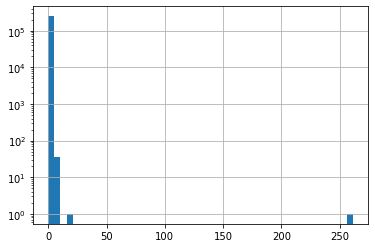

In [14]:
client_profile_df['AMT_REQ_CREDIT_BUREAU_QRT'].hist(log=True,bins=50)

### Здесь, скорее всего тоже выброс. 

In [15]:
client_profile_df.loc[(client_profile_df['AMT_REQ_CREDIT_BUREAU_QRT']>50),'AMT_REQ_CREDIT_BUREAU_QRT'] /= 10

In [16]:
client_profile_df[['DAYS_ON_LAST_JOB', 'OWN_CAR_AGE','FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE']].describe()

,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE
count,250000.000000,85041.000000,250000.000000,250000.000000,249998.000000
mean,184.947625,12.030221,0.280244,0.057072,2.154025
std,381.537259,11.899404,0.449119,0.231981,0.911543
min,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.550685,5.000000,0.000000,0.000000,2.000000
50%,6.073973,9.000000,0.000000,0.000000,2.000000
75%,15.556164,15.000000,1.000000,0.000000,3.000000
max,1000.665753,69.000000,1.000000,1.000000,20.000000


In [17]:
client_profile_df.describe()

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,...,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,2.500000e+05,250000.000000,250000.000000,2.500000e+05,2.500000e+05,249989.000000,250000.000000,250000.000000,250000.000000,250000.000000,...,249998.000000,109121.000000,2.494680e+05,200462.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000,250000.000000
mean,1.235771e+08,0.341404,0.417624,1.685338e+05,5.993051e+05,27125.209585,1.509648,0.446794,0.020871,43.927289,...,2.154025,0.502122,5.141749e-01,0.510848,0.005492,0.005940,0.029604,0.231412,0.229876,1.642988
std,8.877722e+04,0.474182,0.722529,1.055593e+05,4.022720e+05,14503.930366,0.874491,0.257469,0.013827,11.948856,...,0.911543,0.210817,1.910938e-01,0.195054,0.077961,0.100443,0.190136,0.855523,0.580702,1.855330
min,1.234233e+08,0.000000,0.000000,2.565000e+04,4.500000e+04,1615.500000,0.000000,0.000008,0.000290,20.517808,...,1.000000,0.014691,8.173617e-08,0.000527,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.235002e+08,0.000000,0.000000,1.125000e+05,2.700000e+05,16524.000000,1.000000,0.147532,0.010006,34.013699,...,2.000000,0.334180,3.920026e-01,0.370650,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.235772e+08,0.000000,0.000000,1.485000e+05,5.147775e+05,24930.000000,1.000000,0.639384,0.018850,43.134247,...,2.000000,0.506018,5.656713e-01,0.535276,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.236540e+08,1.000000,1.000000,2.025000e+05,8.086500e+05,34618.500000,2.000000,0.639384,0.028663,53.920548,...,3.000000,0.674793,6.635195e-01,0.669057,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
max,1.237309e+08,1.000000,19.000000,1.350000e+07,4.050000e+06,230161.500000,4.000000,0.639384,0.072508,69.120548,...,20.000000,0.962693,8.549997e-01,0.896010,4.000000,9.000000,8.000000,27.000000,26.100000,25.000000


<AxesSubplot:>

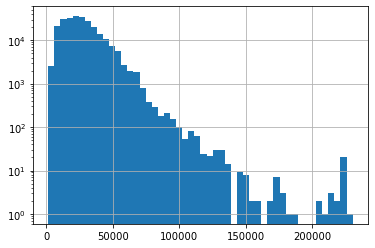

In [18]:
client_profile_df['AMOUNT_ANNUITY'].hist(log=True, bins=50)

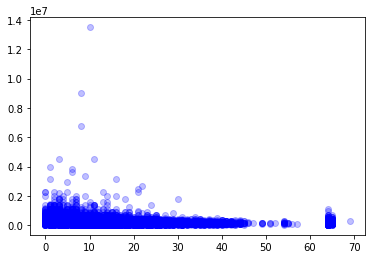

In [19]:
plt.scatter(client_profile_df['OWN_CAR_AGE'], client_profile_df['TOTAL_SALARY'], alpha=0.25, color="blue")

## Объединим все интересующие нас таблицы в одну. создадим новые признаки.

Основная проблема в данной задаче состоит в том, что не для всех люей существоет запись в таблице профиля пользователя. Такое ощущение, будто  их специально удалили. так как и в таблице БКИ и  app_history записи для всех пользователей присутствуют. 
И это создает проблемму. т.к. для этих пользователей предсказать вероятность возврата кредита оказывается достаточно сложно. 
Для того чтобы это исправить заполним пропуски наиболее часто встречающимися значениями в категориях.

In [20]:
def df_prepare(source_df, join_type ='left', is_fulling_delay=False):
    source_df = source_df.copy(deep=True)
    # client_profile_df_1 = category_to_digit(client_profile_df, ['EDUCATION_LEVEL', 'FAMILY_STATUS'])
    client_profile_df_1 = client_profile_df.copy(deep=True) # get_freq_encoder(client_profile_df, ['EDUCATION_LEVEL', 'FAMILY_STATUS'])
    
    

    df = source_df.merge(client_profile_df_1, how=join_type, on='APPLICATION_NUMBER')
    df = get_freq_encoder(df, ['NAME_CONTRACT_TYPE'])
    
    # Заполняем пропуски.
    #--------------------------------------------------------------------------------------
    # заполним пропуски в таблице наиболее часто встречающимися значениями.
    if is_fulling_delay:
        features = df.columns.values
        # features = features[:-5]
        for feature in features:
            values = df[feature].value_counts()
            most_popular  = values.index[0]
            # len_values = len(values)
            df.loc[(df[feature].isna()),feature] = most_popular
 
    #--------------------------------------------------------------------------------------
    # Создание новых признаков

    df["EXTERNAL_SCORING_RATING"] = (df["EXTERNAL_SCORING_RATING_1"] * df["EXTERNAL_SCORING_RATING_2"] * df["EXTERNAL_SCORING_RATING_3"])
    df["EXTERNAL_SCORING_RATING_SUM"] = (df["EXTERNAL_SCORING_RATING_1"] + df["EXTERNAL_SCORING_RATING_2"] + df["EXTERNAL_SCORING_RATING_3"])
 
    df["CREDIT_AGE_LONG"] = df["AMOUNT_CREDIT"]/(df["AMOUNT_ANNUITY"]*12)

    df['SOLVENCY'] = df['TOTAL_SALARY']/df["AMOUNT_ANNUITY"] 

    # Возраст человека полсе того как кредит будет выплачен.
    df['AGE_AFTER'] = df['AGE'] + df["CREDIT_AGE_LONG"] 

    # Судя по всему, к-во запросов в кредитное бюро по клиенту за день, неделю, месяц, квартал как-то коррелирует с суммой кредита.
    # Поэтому, эти показатели наверное имее смысл просуммировать с разными весами.
    df['AMT_REQ_CREDIT_BUREAU'] = (1*df['AMT_REQ_CREDIT_BUREAU_HOUR']+
                                2*df['AMT_REQ_CREDIT_BUREAU_DAY']+
                                3*df['AMT_REQ_CREDIT_BUREAU_WEEK']+
                                4*df['AMT_REQ_CREDIT_BUREAU_MON']+
                                6*df['AMT_REQ_CREDIT_BUREAU_QRT']+
                                7*df['AMT_REQ_CREDIT_BUREAU_YEAR'])

    # if (is_bki_merge & is_payment_merge):
    #     df['active_credits_payment']= df['active_credits']/df['payments_credits_count'] # по какому к-ву кредитов из активных на текущий момент клиент уже произвел выплаты.
    #     df.loc[(df['active_credits']==0),'active_credits_payment'] = df.loc[(df['active_credits']==0),'payments_credits_count']
    #     # if is_fulling_delay:
    #     values = df['active_credits_payment'].value_counts()
    #     most_popular  = values.index[0]
    #     # len_values = len(values)
    #     df.loc[(df['active_credits_payment'].isna()),'active_credits_payment'] = most_popular


    return df

# Обучение модели.

In [21]:
# Функция для выполнения балансировки классов.

def balance_df_by_target(df, target_name, method='over'):

    assert method in ['over', 'under', 'tomek', 'smote'], 'Неверный метод сэмплирования'
    
    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1
    if method == 'over':
        for i in range(disbalance_coeff):
            sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
            df = df.append(sample, ignore_index=True)
            
    elif method == 'under':
        df_ = df.copy()
        df = df_[df_[target_name] == minor_class_name]
        tmp = df_[df_[target_name] == major_class_name]
        df = df.append(tmp.iloc[
            np.random.randint(0, tmp.shape[0], target_counts[minor_class_name])
        ], ignore_index=True)

    elif method == 'tomek':
        from imblearn.under_sampling import TomekLinks
        tl = TomekLinks()
        X_tomek, y_tomek = tl.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_tomek, y_tomek], axis=1)
    
    elif method == 'smote':
        from imblearn.over_sampling import SMOTE
        smote = SMOTE()
        X_smote, y_smote = smote.fit_sample(df.drop(columns=target_name), df[target_name])
        df = pd.concat([X_smote, y_smote], axis=1)

    return df.sample(frac=1) 

In [22]:
# df = df_prepare(train_df,join_type='left')

In [23]:
# df.head(3)

In [24]:
# Коэфициент для балансировки классов.

# disbalance = df["TARGET"].value_counts()[0] / df["TARGET"].value_counts()[1]
# disbalance

In [25]:
def test_data_prediction(model_name, estimators: object, is_fulling_delay=False):
    test_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/test.csv')
    test_df.head(4)

    test = df_prepare(test_df, is_fulling_delay=is_fulling_delay)

    final_id = test['APPLICATION_NUMBER']
    x_data = test.drop(["APPLICATION_NUMBER"], axis=1)

  # Прогноз
    y_pred = np.zeros(x_data.shape[0])

    for estimator in estimators:
        y_pred += estimator.predict_proba(x_data)[:, 1]
        
    y_pred=y_pred/len(estimators)

    df_final = pd.DataFrame({'APPLICATION_NUMBER':final_id, 'TARGET':list(y_pred)})
    
    # model_index+=1
    df_final.to_csv(f'prediction_{model_name}.csv', index=False, encoding='utf-8')

In [26]:
def make_cross_validation(X: pd.DataFrame,
                          y: pd.Series,
                          estimator: object,
                          metric: callable,
                          cv_strategy):
    """
    Кросс-валидация.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):    
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]
        

        estimator.fit(x_train, y_train,
                      eval_set=[(x_train, y_train), (x_valid, y_valid)],
                    # verbose=False
                      verbose=450
                      )
        y_train_pred = estimator.predict_proba(x_train)[:,1]
        y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        # print(y_train_pred.shape, y_train.shape)
        fold_train_scores.append(metric(y_train, y_train_pred))
        fold_valid_scores.append(metric(y_valid, y_valid_pred))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        print(msg)
        print("="*69)
        estimators.append(estimator)

    oof_score = metric(y, oof_predictions)
    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [27]:
def evalute_model(df, estimator: object, metric: callable, model_name='',  is_KFold = False, is_balanced=True):

 # Разделим выборки на тренировчную, тестовую и валидационную.
    x_train, x_test = train_test_split(df.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), train_size=0.60, shuffle=True, random_state=1)
    y_train, y_test = train_test_split(df["TARGET"], train_size=0.60, shuffle=True, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

    x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=True, random_state=1,)
    y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=True, random_state=1,)

    if is_balanced:
      df_for_balancing = pd.concat([x_train, y_train], axis=1)
      df_balanced = balance_df_by_target(df_for_balancing, "TARGET", method='over')
          
      x_train = df_balanced.drop(columns="TARGET")
      y_train = df_balanced["TARGET"]

    estimator = estimator
    
    if is_KFold:
#-------------------------------------
        x_train = pd.concat([x_train, x_val], axis=0,ignore_index=True)
        y_train = pd.concat([y_train, y_val], axis=0,ignore_index=True)

        cv_strategy = KFold(n_splits=5, random_state=1, shuffle=True)

        estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_cross_validation(
        x_train, y_train, estimator, metric=metric, cv_strategy=cv_strategy )

        ## Прогноз
        #----------------------------------
        y_pred_train = np.zeros(x_train.shape[0])

        for estimator in estimators:
            y_pred_train += estimator.predict_proba(x_train)[:,1]

        y_pred_train = y_pred_train/cv_strategy.n_splits

        train_score = metric(y_train, y_pred_train)
        #----------------------------------
        y_pred_val = np.zeros(x_val.shape[0])

        for estimator in estimators:
            y_pred_val += estimator.predict_proba(x_val)[:,1]

        y_pred_val = y_pred_val/cv_strategy.n_splits

        val_score = metric(y_val, y_pred_val)
        #-----------------------------------
        y_pred_test = np.zeros(x_test.shape[0])

        for estimator in estimators:
            y_pred_test += estimator.predict_proba(x_test)[:,1]

        y_pred_test = y_pred_test/cv_strategy.n_splits

        test_score = metric(y_test, y_pred_test)
    
        estimator = estimators

        clear_output(wait=True) # Очищаем поле вывода.   
         
        print(f"\r\n 'OOF-score: {round(oof_score, 3)}, Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")
        
        return estimator, oof_predictions, y_pred_train, y_pred_val, y_pred_test
#-------------------------------------
    else:
#-------------------------------------
        estimator.fit(
            X=x_train,
            y=y_train,
            eval_set=[(x_train, y_train), (x_val, y_val)],
            verbose=100,
            
        )
        train_score = metric(y_train, estimator.predict_proba(x_train)[:,1])
        val_score = metric(y_val, estimator.predict_proba(x_val)[:,1])
        test_score = metric(y_test, estimator.predict_proba(x_test)[:,1])

        clear_output(wait=True) # Очищаем поле вывода.   
         
        print(f"\r\n 'Train-score: {round(train_score, 3)}, Val-score: {round(val_score, 3)}, Test-score: {round(test_score, 3)}")
        
        return estimator

In [28]:
lgbm_model = lgb.LGBMClassifier(
        boosting_type="gbdt",
        objective ="binary",
        metric = "auc",
        learning_rate = 0.1,
        n_estimators = 10000,
        reg_lambda = 50,
        max_depth = 4,
        random_state = 1,
        early_stopping_round=500
       )

In [29]:
xgb_model = xgb.XGBClassifier(
        booster="gbtree",
        # objective ="binary",
        eval_metric = "auc",
        learning_rate = 0.1,
        n_estimators = 500,
        reg_lambda = 50,
        max_depth = 4,
        random_state = 1,
        # early_stopping_rounds=500
       )

In [30]:
catb_model = catb.CatBoostClassifier(silent=True, random_state=21,
                                    # class_weights=[1, disbalance], # <== ^_^
                                    score_function='L2',
                                    depth = 7,
                                    eval_metric='AUC',
                                    use_best_model=True,
                                    boosting_type = 'Ordered', #  / Plain 
                                    l2_leaf_reg = 3, # -- регуляризация. 3.0 = по умолчанию. 
                                    # eta = 0.5,
                                    learning_rate=0.01,
                                    custom_metric=['Precision', 'Recall'],
                                    iterations=10000,
                                    early_stopping_rounds=500,
                                    # verbose=True
                                )

### Задание 1.
 Обучить алгоритмы LightGBM и XGBoost, получить OOF прогнозы, оценить корреляцию прогнозов на обучающей выборке. Применить модели на тестовую выборку и оценить корреляцию.

In [31]:
model_name = 'lgbm_model'; is_KFold = True; is_fulling_delay=False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay)

lgbm_estimator, lgbm_oof_preds, lgbm_train_preds, lgbm_val_preds, lgbm_test_preds  = evalute_model(df, lgbm_model, metric=roc_auc_score, model_name=model_name, is_KFold=is_KFold, is_balanced=False)


 'OOF-score: 0.729, Train-score: 0.782, Val-score: 0.781, Test-score: 0.729


In [32]:
model_name = 'xgb_model'; is_KFold = True; is_fulling_delay=False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay)

xgb_estimator, xgb_oof_preds, xgb_train_preds, xgb_val_preds, xgb_test_preds  = evalute_model(df, xgb_model, metric=roc_auc_score, model_name=model_name, is_KFold=is_KFold, is_balanced=False)


 'OOF-score: 0.729, Train-score: 0.789, Val-score: 0.789, Test-score: 0.73


In [52]:
scores = pd.DataFrame({
    "lgbm_oof_preds": lgbm_oof_preds,
    "xgb_oof_preds": xgb_oof_preds,
})

oof_corr = scores.corr()
oof_corr

,lgbm_oof_preds,xgb_oof_preds
lgbm_oof_preds,1.000000,0.970983
xgb_oof_preds,0.970983,1.000000


In [53]:
scores = pd.DataFrame({
    "lgbm_train_preds": lgbm_train_preds,
    "xgb_train_preds": xgb_train_preds,
})

train_corr = scores.corr()
train_corr

,lgbm_train_preds,xgb_train_preds
lgbm_train_preds,1.000000,0.978271
xgb_train_preds,0.978271,1.000000


Построим предсказания полученных поделей для тестовой выборки.

In [35]:
def test_data_prediction(estimators: object, is_fulling_delay=False):
    test_df = pd.read_csv('../data/geekbrains-competitive-data-analysis/test.csv')
    test_df.head(4)

    test = df_prepare(test_df, is_fulling_delay=is_fulling_delay)

    final_id = test['APPLICATION_NUMBER']
    x_data = test.drop(["APPLICATION_NUMBER"], axis=1)

  # Прогноз
    y_pred = np.zeros(x_data.shape[0])

    for estimator in estimators:
        y_pred += estimator.predict_proba(x_data)[:, 1]
        
    y_pred=y_pred/len(estimators)

    return y_pred

In [36]:
lgbm_test_ds_preds = test_data_prediction(lgbm_estimator, is_fulling_delay=False)

In [37]:
xgb_test_ds_preds = test_data_prediction(xgb_estimator, is_fulling_delay=False)

In [54]:
scores = pd.DataFrame({
    "lgbm_test_df_preds": lgbm_test_ds_preds,
    "xgb_test_df_preds": xgb_test_ds_preds,
})

test_df_corr = scores.corr()
test_df_corr

,lgbm_test_df_preds,xgb_test_df_preds
lgbm_test_df_preds,1.00000,0.97642
xgb_test_df_preds,0.97642,1.00000


 ### Задание 2.
  Усреднить прогнозы с помощью арифмитического среднего, геометрического среднего и усреднить ранги, сделать выводы о качестве отдельных моделей и о качестве комбинации.

In [55]:
 # Разделим выборки на тренировчную, тестовую и валидационную.
x_train, x_test = train_test_split(df.drop(["APPLICATION_NUMBER", "TARGET"], axis=1), train_size=0.60, shuffle=True, random_state=1)
y_train, y_test = train_test_split(df["TARGET"], train_size=0.60, shuffle=True, random_state=1,) # В данных имеется временная зависимость, поэтому пока перемешивать ничего не будем.

x_test, x_val = train_test_split(x_test, train_size=0.50, shuffle=True, random_state=1,)
y_test, y_val = train_test_split(y_test, train_size=0.50, shuffle=True, random_state=1,)

In [56]:
# Прогноз
lgbm_pred = np.zeros(x_test.shape[0])

for estimator in lgbm_estimator:
    lgbm_pred += estimator.predict_proba(x_test)[:, 1]
    
lgbm_pred=lgbm_pred/len(lgbm_estimator)

# Прогноз
xgb_pred = np.zeros(x_test.shape[0])

for estimator in xgb_estimator:
    xgb_pred += estimator.predict_proba(x_test)[:, 1]
    
xgb_pred=xgb_pred/len(xgb_estimator)

In [57]:
test_scores = pd.DataFrame({
    "lgbm_pred": lgbm_pred,
    "xgb_pred": xgb_pred,
})

In [58]:
## AMean
scores_mean = test_scores.mean(axis=1)
score = roc_auc_score(y_test, scores_mean)
print(f"Score_mean = {round(score, 4)}")

## GMean
scores_gmean = gmean(test_scores, axis=1)
score = roc_auc_score(y_test, scores_gmean)
print(f"Score_gmean = {round(score, 4)}")

## Rankdata
# ROC-AUC / GINI
scores_rank_mean = test_scores.rank().mean(axis=1)
score = roc_auc_score(y_test, scores_rank_mean)
print(f"Score_rank_mean = {round(score, 4)}")

Score_mean = 0.7297
Score_gmean = 0.7296
Score_rank_mean = 0.7295


### Задание 3.
Обучить CatBoost, получить OOF прогнозы и выполнить задание 1 для трех моделей.
Выполнить задание 2 для трех моделей.   

In [59]:
model_name = 'catb_model'; is_KFold = True; is_fulling_delay=False

df = df_prepare(train_df,join_type='left', is_fulling_delay=is_fulling_delay)

catb_estimator, catb_oof_preds, catb_train_preds, catb_val_preds, catb_test_preds  = evalute_model(df, catb_model, metric=roc_auc_score,model_name=model_name, is_KFold=is_KFold, is_balanced=False)


 'OOF-score: 0.728, Train-score: 0.77, Val-score: 0.771, Test-score: 0.73


In [60]:
# Прогноз
catb_pred = np.zeros(x_test.shape[0])

for estimator in catb_estimator:
    catb_pred += estimator.predict_proba(x_test)[:, 1]
    
catb_pred=catb_pred/len(catb_estimator)

In [61]:
test_scores = pd.DataFrame({
    "lgbm_pred": lgbm_pred,
    "xgb_pred": xgb_pred,
    "catb_pred": catb_pred,
})

test_corr = test_scores.corr()
test_corr

,lgbm_pred,xgb_pred,catb_pred
lgbm_pred,1.000000,0.977147,0.958061
xgb_pred,0.977147,1.000000,0.954032
catb_pred,0.958061,0.954032,1.000000


In [62]:
## AMean
scores_mean = test_scores.mean(axis=1)
score = roc_auc_score(y_test, scores_mean)
print(f"Score_mean = {round(score, 4)}")

## GMean
scores_gmean = gmean(test_scores, axis=1)
score = roc_auc_score(y_test, scores_gmean)
print(f"Score_gmean = {round(score, 4)}")

## Rankdata
# ROC-AUC / GINI
scores_rank_mean = test_scores.rank().mean(axis=1)
score = roc_auc_score(y_test, scores_rank_mean)
print(f"Score_rank_mean = {round(score, 4)}")

Score_mean = 0.7322
Score_gmean = 0.7319
Score_rank_mean = 0.7323


### Задание 4. (опция)
Объединить OOF-прогнозы для трех моделей и обучить алгоритм Логистической регрессии (и любой другой, на ваше усмотрение). Сделать выводы о достигаемом качестве, сравнить достигаемое качество с качеством отдельных моделей и моделей, полученных в п.2 и п.3.

### Задание 5. (опция)
Обучить алгоритм RandomForest (желательно подтюнить параметры) и добавить к построенным ранее моделям. Выполнить задание 4.